# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак

- Exited — факт ухода клиента

## Подготовка данных

###  Загрузим библиотеки и исследуем данные

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
!pip install BorutaShap[all]
#from BorutaShap import BorutaShap
from xgboost import XGBClassifier

     |████████████████████████████████| 567 kB 1.3 MB/s eta 0:00:01


In [ ]:
data = pd.read_csv('/datasets/Churn.csv')

In [ ]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


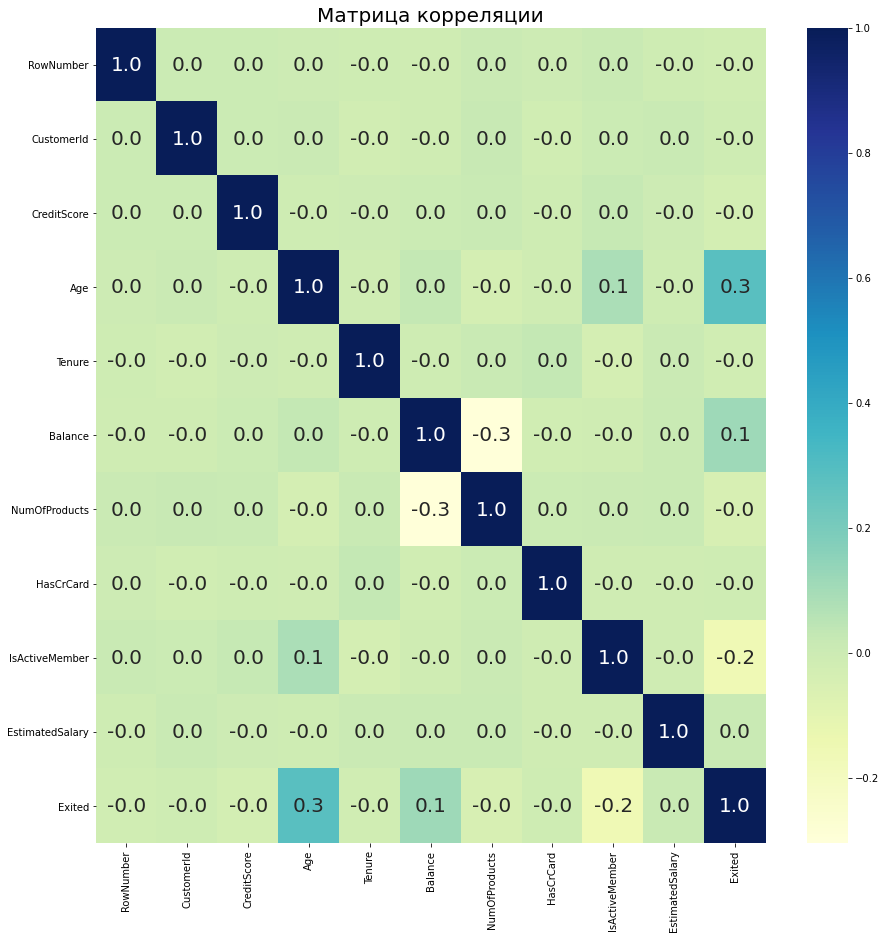

In [ ]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True, annot_kws = {'size':20}, fmt='.1f')
ax.set_title('Матрица корреляции', color = 'black', size = 20)

plt.show()

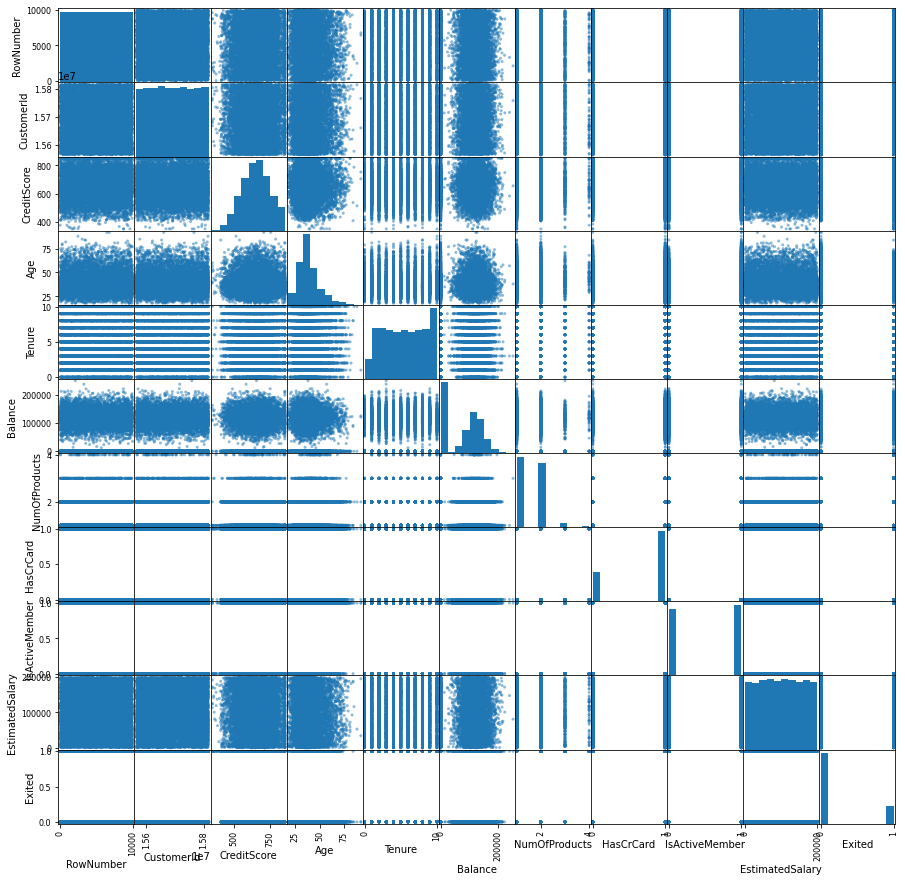

In [ ]:
pd.plotting.scatter_matrix(data, figsize=(15,15))
plt.show()

***Вывод: мы имеем набор данных, состоящий из 10 000 строк и 14 столбцов. Имеются пропущенные значения в столбце "Tenure". При построении матрицы корреляции, явных коррелирующих признаков не обнаружено.***

### Подготовим данные для машинного обучения

**В обучении модели нам не пригодятся столбцы Surname,
CustomerId, RowNumber поэтому сразу удалим их**

In [ ]:
data = data.drop(['Surname', 'CustomerId', 'RowNumber'], axis=1)

**Закодируем данные при помощи  pd.get_dummies() с аргументом drop_first**

In [ ]:
data_ohe = pd.get_dummies(data, drop_first=True)

**Заполним медианой пропущенные значения в столбце Tenure**

In [ ]:
data_ohe['Tenure'] = data_ohe['Tenure'].fillna(data_ohe['Tenure'].median())

In [ ]:
data_ohe = data_ohe.astype('int64') # приведем данные к числовому формату

In [ ]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   CreditScore        10000 non-null  int64
 1   Age                10000 non-null  int64
 2   Tenure             10000 non-null  int64
 3   Balance            10000 non-null  int64
 4   NumOfProducts      10000 non-null  int64
 5   HasCrCard          10000 non-null  int64
 6   IsActiveMember     10000 non-null  int64
 7   EstimatedSalary    10000 non-null  int64
 8   Exited             10000 non-null  int64
 9   Geography_Germany  10000 non-null  int64
 10  Geography_Spain    10000 non-null  int64
 11  Gender_Male        10000 non-null  int64
dtypes: int64(12)
memory usage: 937.6 KB


In [ ]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0,1,1,1,101348,1,0,0,0
1,608,41,1,83807,1,0,1,112542,0,0,1,0
2,502,42,8,159660,3,1,0,113931,1,0,0,0
3,699,39,1,0,2,0,0,93826,0,0,0,0
4,850,43,2,125510,1,1,1,79084,0,0,1,0


***Вывод: в данном пункте мы удалили ненужные столбцы, провели кодировку данных, а также заполнили пропущенные значения и привели все к числовому формату. Данные имеют разный масштаб, исправим это следующим этапом***

<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошо, что для заполнения пропусков использовалась медиана!
</div>

### Разделим исходные данные на обучающую, тестовую и валидационную выборки

In [ ]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

In [ ]:
features_all, features_valid, target_all, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features_all, target_all, test_size=0.25, random_state=12345)

**Проверим наши выборки**

In [ ]:
features_valid.shape

(2500, 11)

In [ ]:
features_valid

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7867,640,46,3,0,1,1,1,156260,0,1,0
1402,757,29,8,130306,1,1,0,77469,0,0,1
8606,807,42,5,0,2,1,1,74900,0,1,1
8885,668,45,4,102486,2,1,1,158379,0,1,1
6494,699,28,7,0,2,1,1,22684,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2149,836,57,4,101247,1,1,0,37141,0,1,1
6328,790,41,7,109508,1,0,0,86776,0,1,0
3952,594,34,7,141525,1,0,0,9443,0,0,0
7480,490,40,6,156111,1,0,0,190889,0,1,1


In [ ]:
features_train.shape

(5625, 11)

In [ ]:
features_test.shape

(1875, 11)

**Все верно, в сумме получается 10000 объектов**

<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано верно. Хорошо, что размеры полученных наборов были напечатаны для самопроверки.
</div>

### Изучим важность признаков

In [ ]:
# Feature_Selector = BorutaShap(importance_measure='shap',
#                               classification=False)
# Feature_Selector.fit(X=features, y=target, n_trials=20, sample=False,
#                      train_or_test = 'test', normalize=True,
#                      verbose=True)
# Feature_Selector.plot(which_features='all')

In [ ]:
# subset = Feature_Selector.Subset()
# subset

**Using BorutaShap with another model XGBoost**

In [ ]:
# model = XGBClassifier()

# # if classification is False it is a Regression problem
# Feature_Selector_1 = BorutaShap(model=model,
#                               importance_measure='shap',
#                               classification=True)

# Feature_Selector_1.fit(X=features, y=target, n_trials=100, sample=False,
#             	     train_or_test = 'test', normalize=True,
# 		     verbose=True)

In [ ]:
# Feature_Selector_1.plot(which_features='all')

In [ ]:
# subset = Feature_Selector.Subset()
# subset

### Масштабируем признаки

**Используем метод StandardScaler для стандартизации данных**

In [ ]:
pd.options.mode.chained_assignment = None
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


print(features_train.head())
print(features_valid.head())
print(features_test.head())
pd.options.mode.chained_assignment = None

      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
9315     0.436123  0.302839  1.073302  0.932268      -0.904415   0.636274   
58      -1.458825  2.563332 -0.377280 -1.217769      -0.904415   0.636274   
4609    -0.733981 -0.450659 -1.465217 -1.217769       0.807340  -1.571649   
9958    -1.189597 -0.168097  0.348011 -1.217769      -0.904415   0.636274   
16       0.011572  1.809834 -1.465217  0.913543      -0.904415   0.636274   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
9315       -1.036026        -1.121733                  0                0   
58         -1.036026        -1.724507                  0                1   
4609        0.965226        -0.345419                  0                1   
9958        0.965226        -1.444310                  0                0   
16         -1.036026        -1.664615                  1                0   

      Gender_Male  
9315            1  
58              0  
4609          

## Исследуем баланс классов, обучим модель без учёта дисбаланса. Кратко опишем выводы.

### Исследуем баланс классов

In [ ]:
class_frequency = data_ohe['Exited'].value_counts(normalize=True)

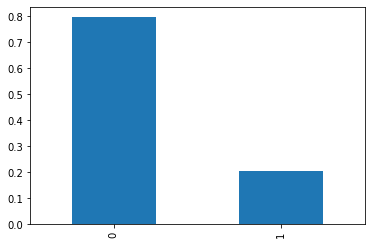

In [ ]:
class_frequency.plot(kind='bar')
plt.show()

In [ ]:
class_frequency

0    0.7963
1    0.2037
Name: Exited, dtype: float64

***Вывод: классы имеют достаточно сильный дисбаланс***

### Обучим модель без учёта дисбаланса

**Подберем оптимальные параметры для случайного леса и решающего дерева**

**Случайный лес**

In [ ]:
best_result = 0
best_model = None
for depth in range(1, 10):
    for estimators in range (1, 10):
        model = RandomForestClassifier(max_depth=depth, n_estimators=estimators, random_state=12345)
        model.fit(features_train, target_train)
        predict = model.predict(features_valid)
        result = f1_score(target_valid, predict)
        if result > best_result:
            best_result = result
            best_model = model
print(best_result)
print(best_model)

0.5580838323353293
RandomForestClassifier(max_depth=9, n_estimators=7, random_state=12345)


**Решающее дерево**

In [ ]:
best_result = 0
best_model = None
for depth in range(1, 30):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predict = model.predict(features_valid)
    result = f1_score(target_valid, predict)
    if result > best_result:
        best_result = result
        best_model = model
print(best_result)
print(best_model)

0.5548996458087367
DecisionTreeClassifier(max_depth=5, random_state=12345)


**Посчитаем и выведем показатели по трем моделям**

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy_score', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=7,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy_score', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=12345, splitter='best')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Accuracy_score', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Логистическая регрессия
Accuracy_score 0.7988
F1 0.28245363766048504

Случайный лес
Accuracy_score 0.8524
F1 0.5580838323353293

Решающее дерево
Accuracy_score 0.8492
F1 0.5548996458087367



**Построим ROC кривую и найдем модель с большей площадью, соответственно и с большим показателем AUC ROC**

AUC-ROC DecisionTreeClassifier 0.682445126156334
AUC-ROC RandomForestClassifier 0.852037763667927
AUC-ROC LogisticRegression 0.7572347863308839


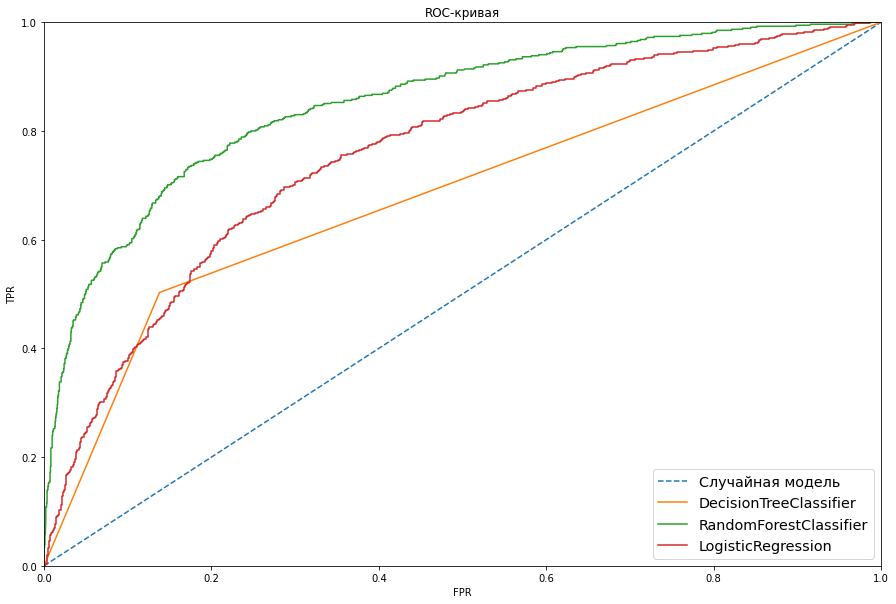

In [ ]:
plt.figure(figsize=[15,10])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')


model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=29,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=12345, splitter='best')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

***Вывод: можем заметить что лучший показатель F1 и AUC ROC у модели случайного леса***

<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошо, что ты уже в этом шаге попробовал несколько разных моделей и реализовал подбор параметров. Радует, что ROC-кривые были визуализированы!
</div>

## Борьба с дисбалансом

### Посмотрим на поведение моделей при взвешенных классах

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy_score', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
                       max_depth=9, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy_score', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=29,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=12345, splitter='best')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Accuracy_score', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Логистическая регрессия
Accuracy_score 0.7036
F1 0.5063291139240507

Случайный лес
Accuracy_score 0.8284
F1 0.6179875333926981

Решающее дерево
Accuracy_score 0.7864
F1 0.5027932960893854



***При взвешенных классах все модели стали вести себя лучше, кроме решающего дерева***

<div class="alert alert-block alert-success">
<b>Успех:</b> Я тоже обычно начинаю с перевзвешивания.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> А можешь соориентировать как рабоает class_weight? И еще вопрос: взвешивание классов и изменение количества выборки всегда применяется отдельно?
</div>

<div class="alert alert-block alert-info">
<b>Совет (ревью 2): </b> Можно применять вместе. class_weight работает перевзвешивает "штраф" за ошибку, то есть он говорит модели, что ошибки на разных классах должны весить обратно пропорционально их доле в выборке. Если класса 1 в 5 раз меньше, чем класса 0, то ошибка на классе 1 в 5 раз важнее.
</div>

### Увеличение выборки

**Исправим дисбаланс посредством увеличения количества признаков положительного класса**

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошо, что параметр repeat был выбран так, чтобы классы стали сбалансированными!
</div>

 **При изменении стратегии борьбы с дисбалансом классов заново подберем параметры**

In [ ]:
best_result = 0
best_model = None
for depth in range(1, 10):
    for estimators in range (1, 10):
        model = RandomForestClassifier(max_depth=depth, n_estimators=estimators, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        predict = model.predict(features_valid)
        result = f1_score(target_valid, predict)
        if result > best_result:
            best_result = result
            best_model = model
print(best_result)
print(best_model)

0.62880658436214
RandomForestClassifier(max_depth=9, n_estimators=9, random_state=12345)


In [ ]:
best_result = 0
best_model = None
for depth in range(1, 30):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predict = model.predict(features_valid)
    result = f1_score(target_valid, predict)
    if result > best_result:
        best_result = result
        best_model = model
print(best_result)
print(best_model)

0.6020984665052462
DecisionTreeClassifier(max_depth=8, random_state=12345)


**Посчитаем показатели модели, обученной на сбалансированных данных 1:1**

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy_score', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy_score', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=12345, splitter='best')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Accuracy_score', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Логистическая регрессия
Accuracy_score 0.7036
F1 0.505670446964643

Случайный лес
Accuracy_score 0.8196
F1 0.62880658436214

Решающее дерево
Accuracy_score 0.8028
F1 0.6020984665052462



***Вывод: при увеличении количества положительных признаков, хорошо себя "чувствуют" все модели. Для далнейшего исследования больше всего подходит модель Случайного леса, на ней и будем проводить тестирование***

<div class="alert alert-block alert-info">
<b>Совет: </b> При изменении стратегии борьбы с дисбалансом классов желательно было заново подобрать параметры.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Я правильно сделал что параметры подбирал на features_upsampled и target_upsampled?
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Подобрал параметры заново
</div>


<div class="alert alert-block alert-success">
<b>Успех (ревью 2)</b> Да, параметры обучать модели при подборе параметров нужно было на измененной выборке.
</div>

## Тестирование модели

***Для теста возьмем самую эффективную модель Случайного леса, с наилучшими гиперпараметрами***

In [ ]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('Дисбаланс классов')
print('accuracy', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('f1', f1_score(target_test, predicted_test))
print('------------------')

model = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
                       max_depth=9, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('Взвешенные классы')
print('accuracy', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('f1', f1_score(target_test, predicted_test))
print('------------------')

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print('Увеличенное количество положительных классов')
print('accuracy', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('f1', f1_score(target_test, predicted_test))
print('------------------')

Дисбаланс классов
accuracy 0.8538666666666667
Precision 0.7345132743362832
Recall 0.4368421052631579
f1 0.5478547854785478
------------------
Взвешенные классы
accuracy 0.8250666666666666
Precision 0.5588235294117647
Recall 0.65
f1 0.6009732360097324
------------------
Увеличенное количество положительных классов
accuracy 0.8112
Precision 0.525691699604743
Recall 0.7
f1 0.600451467268623
------------------


AUC-ROC дисбаланс 0.8588743179017778
AUC-ROC балансированные классы через class weight 0.8416123921844747
AUC-ROC Увеличенное количество положительных классов 0.8576395000880127


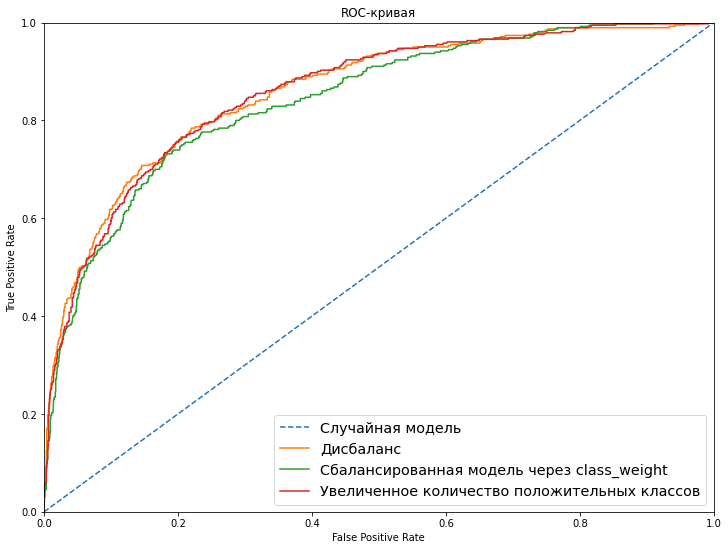

In [ ]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')


model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=7,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC дисбаланс',auc_roc)
plt.plot(fpr, tpr, label='Дисбаланс')

model = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=7,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC балансированные классы через class weight',auc_roc)
plt.plot(fpr, tpr, label='Сбалансированная модель через class_weight')

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC Увеличенное количество положительных классов',auc_roc)
plt.plot(fpr, tpr, label='Увеличенное количество положительных классов')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

***Вывод: в итоге мы получили лучшие показатели по F1 у Случайного леса со взвешенными классами через class weight. Показатель AUC ROC практически равен у всех моделей, даже на дисбалансе он показывает неплохой результат. Таким образом мы нашли оптимальное сочетание:***
- модель - Случайный лес
- гиперпараметры bootstrap=True, class_weight='balanced', criterion='gini',
                       max_depth=9, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False
- взвешенные классы при помощи class_weight


In [ ]:
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet

In [ ]:
y = data['Exited']
x = data.drop('Exited', axis=1)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25)

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
tr = ColumnTransformer([("scaler", StandardScaler(), [0, 3, 5]),
                        ("imputer", SimpleImputer(fill_value=0, strategy="median"), [4]), 
                        ("ohe", OneHotEncoder(sparse=False), [1, 2]),],
                        remainder="passthrough"
                      )


pipe = Pipeline([
                 ("colum", tr),
                 ("model", RandomForestClassifier()) 
                ])

pipe.fit(x_train, y_train)
y_pr = pipe.predict(x_val)
mse2 = mean_squared_error(y_val, y_pr, squared=False)
print('Accuracy_score', accuracy_score(y_val, y_pr))
print('F1', f1_score(y_val, y_pr))

Accuracy_score 0.8612
F1 0.5678704856787049


In [ ]:
params = \
     {"classifier__max_depth": range(1, 10, 2),
     "classifier__n_estimators": range(10, 50, 10),
     "classifier__max_depth": range(2, 6, 2),
     'classifier__random_state': [12345]}


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
x_train.shape

(7500, 10)

In [ ]:
x_val.shape

(2500, 10)

In [ ]:
y_train.shape

(7500,)

In [ ]:
y_val.shape

(2500,)

In [ ]:
tr = ColumnTransformer([("scaler", StandardScaler(), [0, 3, 5]),
                        ("imputer", SimpleImputer(fill_value=0, strategy="median"), [4]), 
                        ("ohe", OneHotEncoder(sparse=False), [1, 2]),],
                        remainder="passthrough"
                      )

In [ ]:
clf = RandomForestClassifier()
steps = [('col', tr), ('classifier', clf)]
pipe = Pipeline(steps)

params = [{"classifier__max_depth": range(1, 20, 5),
     "classifier__n_estimators": range(10,50, 10),
     'classifier__random_state': [543]}]

grid_search = GridSearchCV(pipe, params)

grid_search.fit(x_train, y_train)
predict = grid_search.predict(x_val)

print('Accuracy_score', accuracy_score(y_val, predict))
print('F1', f1_score(y_val, predict))

Accuracy_score 0.8656
F1 0.5647668393782384


In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  [0, 3, 5]),
                                                 ('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='median'),
                                                  [4]),
                                                 ('ohe',
                                                  OneHotEncoder(sparse=False),
                                                  [1, 2])])),
                ('classifier',
                 RandomForestClassifier(max_depth=11, n_estimators=40,
                                        random_state=543))])

In [ ]:
print('Accuracy_score', accuracy_score(y_val, y_pr))
print('F1', f1_score(y_val, y_pr))

Accuracy_score 0.8612
F1 0.5678704856787049


In [ ]:
target_valid.shape

(2500,)

In [ ]:
predict.shape

(2500,)

Случайный лес
Accuracy_score 0.8196
F1 0.62880658436214

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.